In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.layers import Dense
import requests
import urllib.parse
import json
from math import radians, sin, cos, sqrt, atan2



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#Extract data from CSV
df1=pd.read_csv("csvs/combined_data_good.csv", encoding='utf-8', quotechar='"', delimiter=',')

In [3]:
epoch = datetime(1970, 1, 1)

def mapdateTotime(x):
    try:
        dt = datetime.strptime(x, "%m/%d/%Y")
    except ValueError:
        dt = datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%fZ")
    diff = dt - epoch
    return diff.total_seconds()

df1.time = df1.time.apply(mapdateTotime)

In [4]:
col1 = df1[['time','latitude','longitude', 'plate_boundary_distance']]
col2 = df1['mag']

#Convert to Numpy array
col1_clean = col1.dropna()
col2_clean = col2.dropna()


InputX1 = col1_clean.to_numpy()
InputY1 = col2_clean.to_numpy()


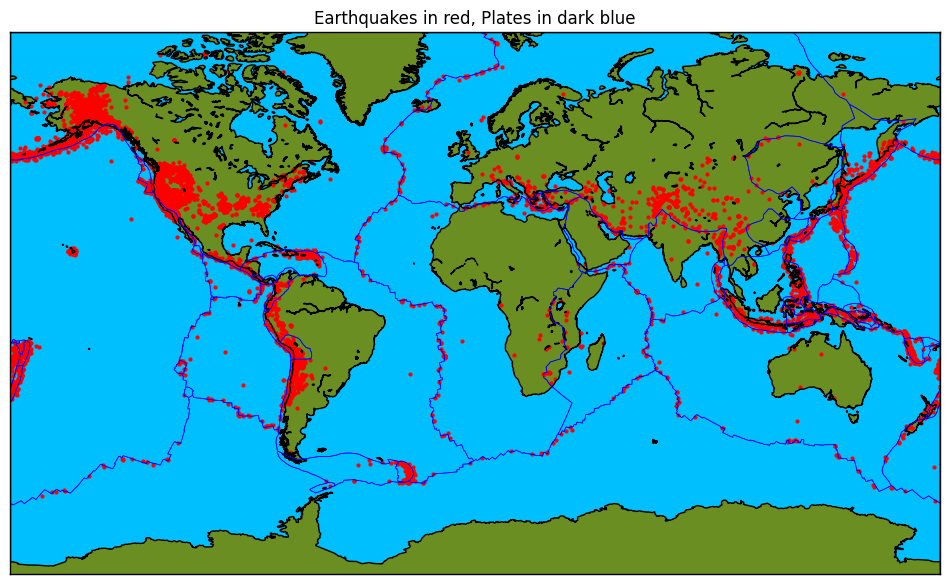

In [5]:
# Visualization

m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='l')
longitudes = df1["longitude"].tolist()
latitudes = df1["latitude"].tolist()
x,y = m(longitudes,latitudes)

fig = plt.figure(figsize=(12,10))
plt.title("Earthquakes in red, Plates in dark blue")
m.plot(x, y, "o", markersize = 2, color = 'red')


m.drawcoastlines()
m.fillcontinents(color='olivedrab',lake_color='deepskyblue')
m.drawmapboundary(fill_color='deepskyblue')
m.readshapefile('tectonicplates-master/PB2002_plates', 
                name='tectonic_plates', 
                drawbounds=True, 
                color='blue')



plt.show()

In [6]:
# Min-max Normalization
X1_min = np.amin(InputX1,0)     
X1_max = np.amax(InputX1,0)   
print("Mininum values:",X1_min)
print("Maximum values:",X1_max)
Y1_min = min(InputY1)     
Y1_max = max(InputY1)

InputX1_norm = (InputX1-X1_min)/(X1_max-X1_min)
InputY1_norm = InputY1  #No normalization in output


# Reshape
Xfeatures = 4 #Number of input features
Yfeatures = 1 #Number of input features
samples = 75000 # Number of samples

InputX1_reshape = np.resize(InputX1_norm,(samples,Xfeatures))
InputY1_reshape = np.resize(InputY1_norm,(samples,Yfeatures))



Mininum values: [ 1.64634343e+09 -6.51963000e+01 -1.79999700e+02  4.52584005e-01]
Maximum values: [1.67088457e+09 8.66293000e+01 1.80000000e+02 3.68528412e+03]


In [218]:
#Training data
batch_size = 64
InputX1train = InputX1_reshape[0:batch_size,:]
InputY1train = InputY1_reshape[0:batch_size,:]

#Validation data
v_size = 15000
InputX1v = InputX1_reshape[batch_size:batch_size+v_size,:]
InputY1v = InputY1_reshape[batch_size:batch_size+v_size,:]



In [200]:
learning_rate = 0.0005
training_iterations = 1000
display_iterations = 100

In [201]:
#Input
X = tf.placeholder(tf.float32,shape=(None,Xfeatures))
#Output
Y = tf.placeholder(tf.float32)

In [202]:
#Neurons
L1 = 3
L2 = 3
L3 = 3

#Layer1 weights
W_fc1 = tf.Variable(tf.random_uniform([Xfeatures,L1]))
b_fc1 = tf.Variable(tf.constant(0.1,shape=[L1]))

#Layer2 weights
W_fc2 = tf.Variable(tf.random_uniform([L1,L2]))
b_fc2 = tf.Variable(tf.constant(0.1,shape=[L2]))

#Layer3 weights
W_fc3 = tf.Variable(tf.random_uniform([L2,L3]))
b_fc3 = tf.Variable(tf.constant(0.1,shape=[L3]))

#Output layer weights
W_fO= tf.Variable(tf.random_uniform([L3,Yfeatures]))
b_fO = tf.Variable(tf.constant(0.1,shape=[Yfeatures]))

In [203]:
# #Layer 1
# matmul_fc1=tf.matmul(X, W_fc1) + b_fc1
# h_fc1 = tf.nn.relu(matmul_fc1)   #ReLU activation
# #Layer 2
# matmul_fc2=tf.matmul(h_fc1, W_fc2) + b_fc2
# h_fc2 = tf.nn.relu(matmul_fc2)   #ReLU activation
# #Layer 3
# matmul_fc3=tf.matmul(h_fc2, W_fc3) + b_fc3
# h_fc3 = tf.nn.relu(matmul_fc3)   #ReLU activation
# #Output layer
# matmul_fc4=tf.matmul(h_fc3, W_fO) + b_fO
# output_layer = matmul_fc4  #linear activation

# Layer 1
h_fc1 = Dense(64, activation='relu')(X)
# Layer 2
h_fc2 = Dense(32, activation='relu')(h_fc1)
# Layer 3
h_fc3 = Dense(16, activation='relu')(h_fc2)
# Output layer
output_layer = Dense(1, activation='linear')(h_fc3)

In [204]:
# Cost
#Loss function
mean_square =  tf.reduce_mean(tf.square(Y-output_layer))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(mean_square)

#Operation to save variables
saver = tf.train.Saver()

In [205]:
# Check if there are any NaN values in InputX1train
if np.isnan(InputX1train).any():
    print("InputX1train contains NaN values.")
    
# Check if there are any NaN values in InputY1train
if np.isnan(InputY1train).any():
    print("InputY1train contains NaN values.")
    
# Check if there are any NaN values in InputX1v
if np.isnan(InputX1v).any():
    print("InputX1v contains NaN values.")
    
# Check if there are any NaN values in InputY1v
if np.isnan(InputY1v).any():
    print("InputY1v contains NaN values.")

In [207]:
#Initialization and session
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    print("Training loss:",sess.run([mean_square],feed_dict={X:InputX1train,Y:InputY1train}))
    for i in range(training_iterations):
        sess.run([train_step],feed_dict={X:InputX1train,Y:InputY1train})
        if i%display_iterations ==0:
            print("Training loss is:",sess.run([mean_square],feed_dict={X:InputX1train,Y:InputY1train}),"at itertion:",i)
            print("Validation loss is:",sess.run([mean_square],feed_dict={X:InputX1v,Y:InputY1v}),"at itertion:",i)
    # Save the variables to disk.
    save_path = saver.save(sess, "/tmp/earthquake_model.ckpt")
    print("Model saved in file: %s" % save_path)

    print("Final training loss:",sess.run([mean_square],feed_dict={X:InputX1train,Y:InputY1train}))
    print("Final validation loss:",sess.run([mean_square],feed_dict={X:InputX1v,Y:InputY1v}))

[0.00267175 0.72410911 0.19092016 0.3020783  0.00263564]
(50000, 1)
Training loss: [4.038856]
Training loss is: [4.001092] at itertion: 0
Validation loss is: [4.1033554] at itertion: 0
Training loss is: [1.4845828] at itertion: 100
Validation loss is: [1.6563538] at itertion: 100
Training loss is: [1.4558157] at itertion: 200
Validation loss is: [1.5896046] at itertion: 200
Training loss is: [1.4397606] at itertion: 300
Validation loss is: [1.5464675] at itertion: 300
Training loss is: [1.4288377] at itertion: 400
Validation loss is: [1.5047377] at itertion: 400
Training loss is: [1.4267949] at itertion: 500
Validation loss is: [1.4936336] at itertion: 500
Training loss is: [1.4258848] at itertion: 600
Validation loss is: [1.4899576] at itertion: 600
Training loss is: [1.4253181] at itertion: 700
Validation loss is: [1.4881554] at itertion: 700
Training loss is: [1.4249281] at itertion: 800
Validation loss is: [1.4869945] at itertion: 800
Training loss is: [1.4246097] at itertion: 900


In [208]:
import json
from math import radians, sin, cos, sqrt, atan2
# Load the plate boundary data from the JSON file
with open("C:/EPSCI10/Seismograph-Earthquake-Detection/tectonicplates-master/GeoJSON/PB2002_boundaries.json") as f:
    data = json.load(f)

# Extract the latitude and longitude coordinates for each boundary point
boundaries = []
for feature in data["features"]:
    for lineString in feature["geometry"]["coordinates"]:
        lon, lat = lineString
        boundaries.append((lat, lon))

def calculate_plate_boundary_dist(long, lat):
    min_distance = float("inf")
    for boundary in boundaries:
        lat1, lon1 = radians(float(lat)), radians(float(long))
        lat2, lon2 = radians(boundary[0]), radians(boundary[1])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = 6371 * c  # Approximate radius of Earth in km
        if distance < min_distance:
            min_distance = distance
    return min_distance

In [212]:
import requests
import urllib.parse

#Testing

address = input("Enter a location (address or informal is fine):")

url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
response = requests.get(url).json()
lat = response[0]["lat"]
long = response[0]["lon"]

plate_boundary_distance = calculate_plate_boundary_dist(long, lat)

date = input("Enter the date (mm/dd/yyyy):")
print(plate_boundary_distance)
InputX2 = np.asarray([[mapdateTotime(date),lat,long,plate_boundary_distance]],dtype=np.float32)
print(InputX2)

InputX2_norm = (InputX2-X1_min)/(X1_max-X1_min)
InputX1test = np.resize(InputX2_norm,(1,Xfeatures))
with tf.Session() as sess:
    # Restore variables from disk for validation.
    saver.restore(sess, "/tmp/earthquake_model.ckpt")
    print("Model restored.")
    #print("Final validation loss:",sess.run([mean_square],feed_dict={X:InputX1v,Y:InputY1v}))
    print("output:",sess.run([output_layer],feed_dict={X:InputX1test}))

    predicted_output = sess.run(output_layer, feed_dict={X: InputX1v})





2922.307549159689
[[ 1.6139520e+09  5.0000679e+01 -8.6000977e+01  2.9223076e+03]]
INFO:tensorflow:Restoring parameters from /tmp/earthquake_model.ckpt
Model restored.
output: [array([[2.2718806]], dtype=float32)]
